# Load Data

In [1]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.stattools import adfuller

# Control figure size
interactive_figures = False
if interactive_figures:
    # Normal behavior
    %matplotlib widget
    figsize=(9, 3)
else:
    # PDF export behavior
    figsize=(14, 4)

# Load the .ori orientation file
ori_path = "/kaggle/input/gamma-data/DC3_final_530km_3_month_with_slew_15sbins_EarthLocal.ori"
ori_df = pd.read_csv(
    ori_path,
    delim_whitespace=True,
    skiprows=1,
    header=None,
    names=["prefix", "timestamp", "x_lat", "x_lon", "z_lat", "z_lon", "altitude_km", "Earth_lat", "Earth_lon"]
)

ori_df.head()

/tmp/ipykernel_31/3329529620.py:21: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  ori_df = pd.read_csv(


,prefix,timestamp,x_lat,x_lon,z_lat,z_lon,altitude_km,Earth_lat,Earth_lon
0,OG,1.835487e+09,59.274529,22.415898,-30.725471,22.415898,530.222097,-0.000190,27.047042
1,OG,1.835487e+09,58.504010,22.732337,-31.495990,22.732337,530.219997,-0.000184,27.927215
2,OG,1.835487e+09,57.732736,23.048787,-32.267264,23.048787,530.216960,-0.000177,28.807377
3,OG,1.835487e+09,56.960731,23.365378,-33.039269,23.365378,530.212986,-0.000171,29.687529
4,OG,1.835487e+09,56.188017,23.682244,-33.811983,23.682244,530.208077,-0.000165,30.567670


In [2]:
# Drop the non-informative 'prefix' column (always 'OG')
ori_df = ori_df.drop(columns=["prefix"])

# Convert timestamps to datetime format
ori_df["timestamp"] = pd.to_datetime(ori_df["timestamp"], unit='s')

# Keep only the first day of data
first_day = ori_df["timestamp"].iloc[0].normalize()
ori_df = ori_df[ori_df["timestamp"] < first_day + pd.Timedelta(days=1)]

ori_df.head()

,timestamp,x_lat,x_lon,z_lat,z_lon,altitude_km,Earth_lat,Earth_lon
0,2028-03-01 01:35:00,59.274529,22.415898,-30.725471,22.415898,530.222097,-0.000190,27.047042
1,2028-03-01 01:35:15,58.504010,22.732337,-31.495990,22.732337,530.219997,-0.000184,27.927215
2,2028-03-01 01:35:30,57.732736,23.048787,-32.267264,23.048787,530.216960,-0.000177,28.807377
3,2028-03-01 01:35:45,56.960731,23.365378,-33.039269,23.365378,530.212986,-0.000171,29.687529
4,2028-03-01 01:36:00,56.188017,23.682244,-33.811983,23.682244,530.208077,-0.000165,30.567670


In [3]:
# Load the detector data and timestamps
time_array = np.load("/kaggle/input/gamma-data/time_array.npy")
rates = np.load("/kaggle/input/gamma-data/total_rates.npy")

# Remove the extra dimension from rates array
rates = np.squeeze(rates)

# Convert time_array to datetime
time_series = pd.to_datetime(time_array, unit='s')

# Create DataFrame with detector rates and timestamp
rates_df = pd.DataFrame(rates, columns=[f"detector_{i+1}" for i in range(rates.shape[1])])
rates_df["timestamp"] = time_series  # <-- This was missing

# Filter from 13:00 onward
cutoff_time = pd.Timestamp("2028-03-01 13:00:00")
clean_rates_df = rates_df[rates_df["timestamp"] >= cutoff_time].copy()

clean_rates_df.head()

,detector_1,detector_2,detector_3,detector_4,detector_5,detector_6,timestamp
2740,1397.333333,1376.333333,1178.866667,1160.466667,1079.000000,1155.533333,2028-03-01 13:00:00.002068042
2741,1355.800000,1363.666667,1173.333333,1141.200000,1058.000000,1129.000000,2028-03-01 13:00:15.002068042
2742,1389.066667,1355.933333,1178.800000,1161.466667,1083.066667,1142.400000,2028-03-01 13:00:30.002068042
2743,1369.066667,1375.733333,1171.266667,1171.600000,1048.600000,1138.666667,2028-03-01 13:00:45.002068042
2744,1385.066667,1395.533333,1197.800000,1167.933333,1100.733333,1155.266667,2028-03-01 13:01:00.002068042


In [4]:
# NaN checks
print("NaNs in rates:", np.isnan(clean_rates_df).sum())

clean_rates_df.describe()

NaNs in rates: detector_1    0
detector_2    0
detector_3    0
detector_4    0
detector_5    0
detector_6    0
timestamp     0
dtype: int64


,detector_1,detector_2,detector_3,detector_4,detector_5,detector_6,timestamp
count,3020.000000,3020.000000,3020.000000,3020.000000,3020.000000,3020.000000,3020
mean,1170.659581,1173.533245,1022.134305,1012.353554,972.930861,946.211015,2028-03-01 19:17:22.502067712
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,2028-03-01 13:00:00.002068042
25%,1355.250000,1344.000000,1189.733333,1134.700000,1106.566667,1087.766667,2028-03-01 16:08:41.252067840
50%,1407.300000,1405.433333,1232.800000,1192.866667,1161.366667,1126.200000,2028-03-01 19:17:22.502067968
75%,1473.416667,1487.400000,1274.133333,1294.916667,1235.616667,1186.333333,2028-03-01 22:26:03.752068096
max,1660.400000,1700.333333,1513.666667,1550.666667,1450.800000,1429.866667,2028-03-02 01:34:45.002068042
std,563.648365,566.162016,492.173764,491.981966,470.080870,457.341063,NaN


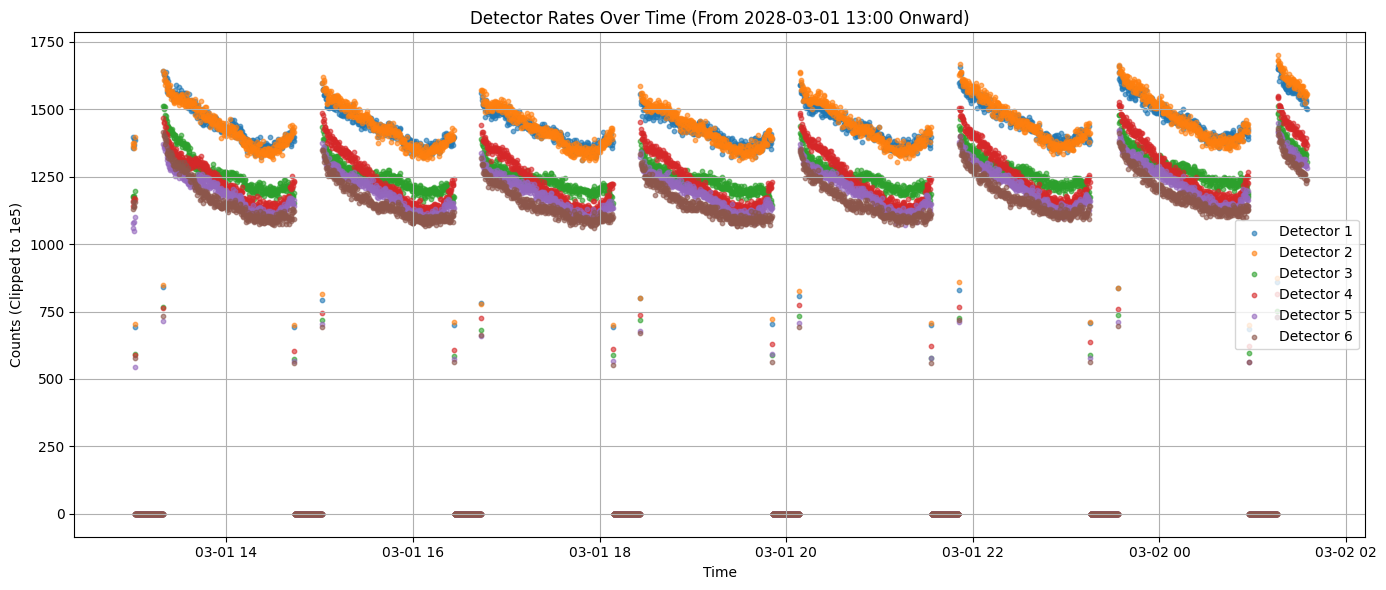

In [5]:
plt.figure(figsize=(14, 6))
for i in range(1, 7):  # detectors 1 to 6
    clipped = clean_rates_df[f'detector_{i}'].clip(upper=1e5)
    plt.scatter(clean_rates_df['timestamp'], clipped, label=f'Detector {i}', alpha=0.6, s=10)  # s=10 sets point size

plt.title("Detector Rates Over Time (From 2028-03-01 13:00 Onward)")
plt.xlabel("Time")
plt.ylabel("Counts (Clipped to 1e5)")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


In [6]:
inputs = clean_rates_df.columns[0:-1]
ninputs = len(inputs)

In [7]:
def plot_dataframe(data, labels=None, vmin=-1.96, vmax=1.96,
        figsize=figsize, s=4):
    plt.figure(figsize=figsize)
    plt.imshow(data.T.iloc[:, :], aspect='auto',
            cmap='RdBu', vmin=vmin, vmax=vmax)
    if labels is not None:
        # nonzero = data.index[labels != 0]
        ncol = len(data.columns)
        lvl = - 0.05 * ncol
        # plt.scatter(nonzero, lvl*np.ones(len(nonzero)),
        #         s=s, color='tab:orange')
        plt.scatter(labels.index, np.ones(len(labels)) * lvl,
                s=s,
                color=plt.get_cmap('tab10')(labels))
    plt.tight_layout()

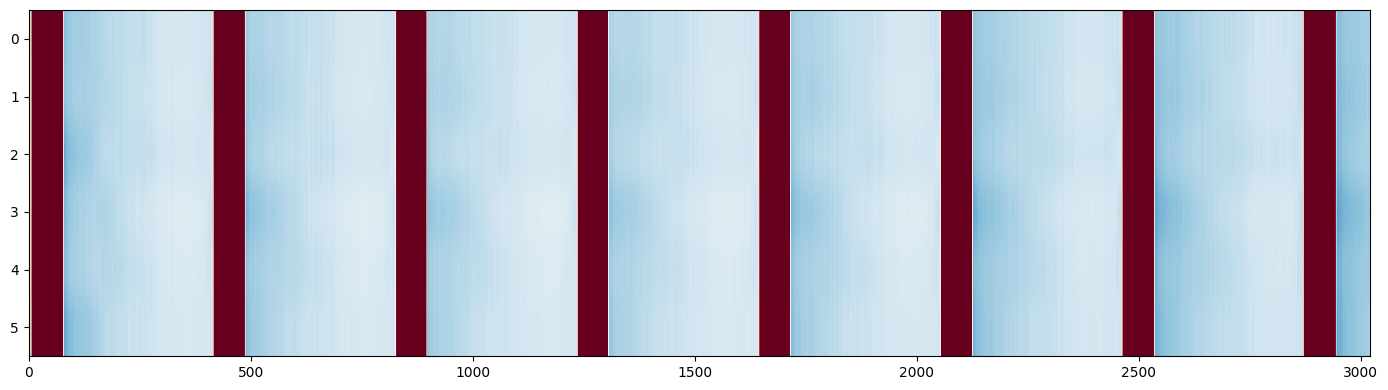

In [8]:
hpcsv = clean_rates_df.copy()

hpcsv[inputs] = (hpcsv[inputs] - hpcsv[inputs].mean()) / hpcsv[inputs].std()

plot_dataframe(hpcsv[inputs], figsize=figsize)

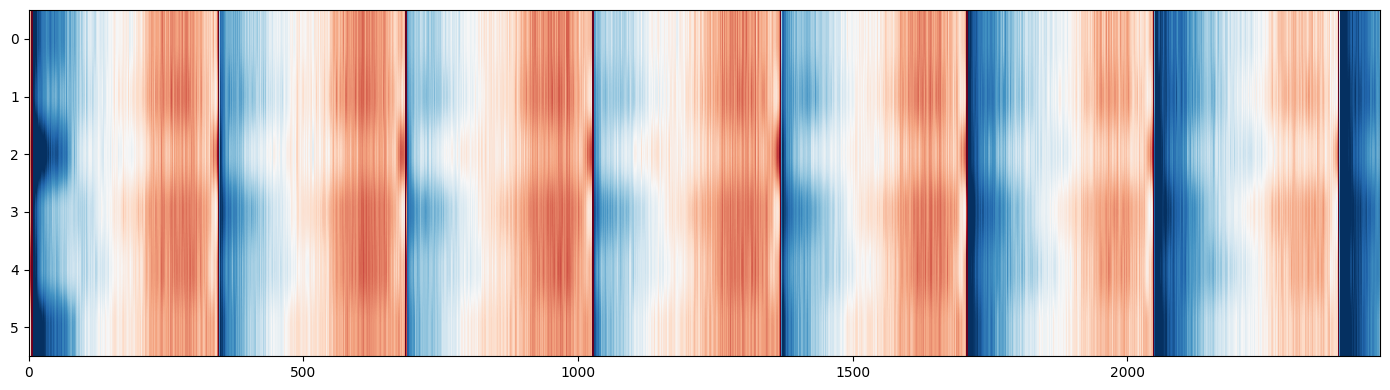

In [9]:
hpcsv = clean_rates_df.copy()

# Remove rows with 0 in any of the inputs columns
hpcsv = hpcsv[~(hpcsv[inputs] == 0).any(axis=1)]

hpcsv[inputs] = (hpcsv[inputs] - hpcsv[inputs].mean()) / hpcsv[inputs].std()

plot_dataframe(hpcsv[inputs], figsize=figsize)
